# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

# Fraud Detection with Machine Learning Methods
In this kernel we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons.

The kernel is built based on python 3.0 with packages like sklearn, numpy and pandas.

## Agenda

1. Load Credit Card Transaction Data
2. Exploratory Data Analysis
3. Model Test and Baseline Result

## Part 1: Load credit card transaction data
- You can fine the Credit Card Fraud Detection project here: https://www.kaggle.com/code/hassanamin/credit-card-fraud-detection-tutorial
- The dataset is from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- Use pandas that you can easily load these data


In [ ]:
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
from google.colab import drive

import gdown

file_id = '1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'creditcard_small.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv('creditcard_small.csv',index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd
To: /content/creditcard_small.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 103MB/s]


## Part 2: Exploratory Data Analysis
- Target: understand the structure and distribution of the data
  - `creditcard.shape` is the shape of the dataset, i.e., the number of rows and columns
  - `Counter(target)` creates a dictionary where the keys are unique class labels, and the counts are frequency of each class. target is a numpy array containing the last column's values (presumably the class labels) from the creditcard dataframe
  - `creditcard['Amount'].describe()` provides descriptive statistics (like count, mean, std, min etc.) of the 'Amount' column in the dataframe
  - The block of code under `from matplotlib import pyplot` creates histograms of all numeric variables in the dataset, except the `'Class'` variable which is dropped using `creditcard.drop('Class', axis=1)`. These histograms are displayed without axis labels to avoid clutter

In [ ]:
# print the shape of the dataset
print(creditcard.shape)

(19999, 30)


In [ ]:
from collections import Counter
# summarize the class distribution
target = creditcard.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=19914, Percentage=99.575%
Class=1, Count=85, Percentage=0.425%


In [ ]:
creditcard['Amount'].describe()

count    19999.000000
mean        70.418629
std        206.053650
min          0.000000
25%          5.800000
50%         16.070000
75%         59.990000
max       7879.420000
Name: Amount, dtype: float64

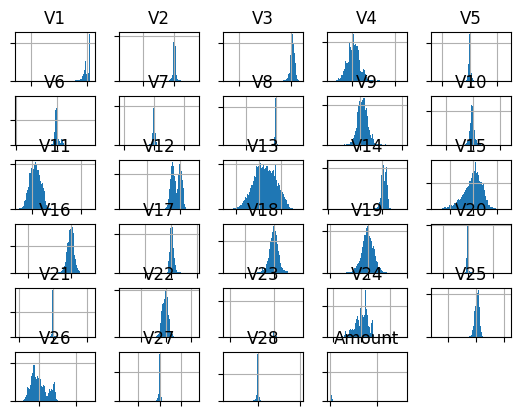

In [ ]:
from matplotlib import pyplot
# drop the target variable
df = creditcard.drop('Class', axis=1)
# create a histogram plot of each numeric variable
ax = df.hist(bins=100)
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
pyplot.show()

## Part 3: Evaluate Machine Learning Algorithms
- Target: load the dataset,  and evaluate several machine learning models
  - `load_dataset(full_path)` loads a dataset from a CSV file located at full_path, converts it into a numpy array, and separates it into input features (X) and output labels (y)
  - `pr_auc(y_true, probas_pred)` calculates the area under the precision-recall curve (AUC-PR) for the given true labels (`y_true`) and predicted probabilities (`probas_pred`)
  - `evaluate_model(X, y, model)` is used to evaluate the performance of a given model using RepeatedStratifiedKFold cross-validation and the AUC-PR as the performance metric
  - `get_models()`: This function defines and returns several machine learning models (Decision Tree, KNN, Bagging, Random Forest, and Extra Trees) and their corresponding names. For KNN, a pipeline is created to standardize the features before applying the model

In [ ]:
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    data = pd.read_csv(full_path,index_col=0,low_memory=False)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    return X, y

In [ ]:
full_path = "./creditcard_small.csv"
# load the dataset
X, y = load_dataset(full_path)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    # calculate area under curve
    return auc(r, p)

In [ ]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

# define models to test
def get_models():
    models, names = list(), list()
    # CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    names.append('KNN')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100))
    names.append('ET')
    return models, names

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>CART 0.869 (0.071)
>KNN 0.921 (0.070)
>BAG 0.919 (0.071)
>RF 0.930 (0.065)
>ET 0.954 (0.053)
